# Homework
The goal of this homework is to create a regression model for predicting the prices (column 'Final Price').

Dataset
In this homework, we will use the Laptops price dataset from Kaggle.

Here's a wget-able link:

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [9]:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../data/laptops.csv')
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [4]:
#Preparing the dataset
#First, we'll normalize the names of the columns:

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [5]:
df= df[['ram','storage','screen','final_price']]


In [6]:
df.dtypes

ram              int64
storage          int64
screen         float64
final_price    float64
dtype: object

In [7]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


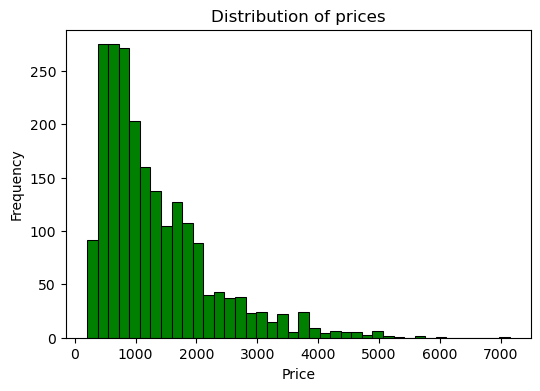

In [10]:
#EDA
#Look at the final_price variable. Does it have a long tail?
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=40, color='green', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

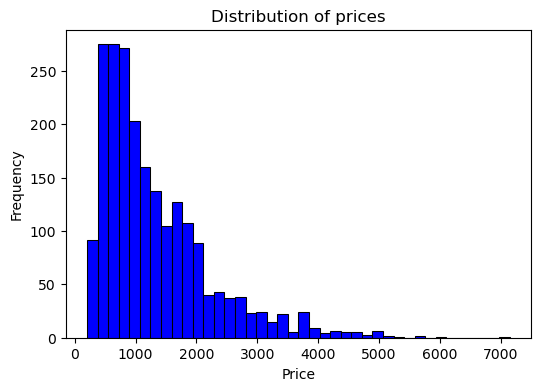

In [11]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price[df.final_price < 100000], bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

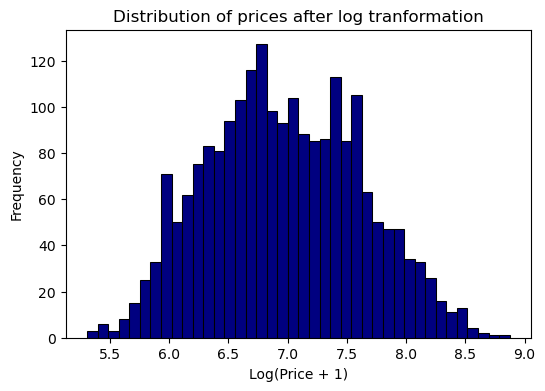

In [12]:
log_price = np.log1p(df.final_price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='navy', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()


## Question 1
There's one column with missing values. What is it?

'screen'


In [14]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'ram'?

16


In [15]:

np.median(df['ram'])

16.0

# Validation framework
Prepare and split the dataset
Shuffle the dataset (the filtered one you created above), use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Use the same code as in the lectures

In [16]:
#SIMPLE LINEAR REGRESSION:

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
#DATASET PREPARATION:


# SPLIT
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

#SHUFFLE
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

In [19]:
# PREPARE
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
     

y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
     


base=['ram','storage','screen']

def prepare_X(df, fillna_value):
    df_num = df[base]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X
     

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)
     



## Question 3
We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?
Options:

Both are equally good

In [21]:
#MISSING VALUES WITH MEAN
mean = df_train.screen.mean()

X_mean_train = prepare_X(df_train, fillna_value=mean)
w_0_mean, w_mean = train_linear_regression(X_mean_train, y_train)
     
X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)
     

np.round(rmse(y_val, y_mean_pred_val),2)

0.43

In [22]:
X_null_train = prepare_X(df_train, fillna_value=0)
w_0_null, w_null = train_linear_regression(X_null_train, y_train)
     

X_null_val = prepare_X(df_val, fillna_value=0)
y_null_pred_val = w_0_null + X_null_val.dot(w_null)
     

np.round(rmse(y_val, y_null_pred_val),2)



0.43

## Question 4
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

Options:

0


In [24]:
#REGULARIZATION


def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
     

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_null_train, y_train, r=r)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    print(r, w_0, rmse_val)
     

0 6.72716370611504 0.43
0.01 6.7210043332629805 0.43
0.1 6.666075503830172 0.43
1 6.162616499462939 0.43
5 4.616086176498074 0.46
10 3.5167547207940193 0.51
100 0.6849263362658934 0.67


# Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))

What's the value of std?


29.176

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.




In [25]:
rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values
    y_test_orig = df_test.final_price.values

    y_train = y_train_orig
    y_val = y_val_orig
    y_test = y_test_orig
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_null_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_null_train, y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)
     

0 547.5696230190905 565.45
1 594.4197428005896 636.8
2 649.4685454773346 588.96
3 571.9459040117479 597.81
4 629.3882030650149 571.96
5 580.7647373333743 573.24
6 783.7683689914218 647.34
7 376.4358600628415 550.44
8 572.8852361202732 587.33
9 663.3792792613488 576.1


In [26]:
rmse_list

[565.45, 636.8, 588.96, 597.81, 571.96, 573.24, 647.34, 550.44, 587.33, 576.1]

In [27]:
np.round(np.std(rmse_list),3)


29.176

## Question 6
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?
Options:

608.60


In [28]:
r = 9

idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
    
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.final_price.values
y_test_orig = df_test.final_price.values

y_train_val = y_train_val_orig
y_test = y_test_orig

del df_train_val['final_price']
del df_test['final_price']
     

#@ INSPECTING RMSE:
X_null_train_val = prepare_X(df_train_val, fillna_value=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

608.61